## Using Anupreeta's code to plot the halo mass

* Terminal commands

```
git clone https://git.ligo.org/anupreeta.more/o4_sims.git
cd o4_sims
pwd
```
* `pwd` will give you the path to the directory

* Follow the readme.md in the [o4_sims](https://git.ligo.org/anupreeta.more/o4_sims) to install the required packages.

* The halo-mass plot [reference](https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/plot_func.py?ref_type=heads#L22)

In [2]:
## Use the following to add the path to the python path
import sys
path = "/Users/phurailatpamhemantakumar/phd/o4_sims" # path to the directory containing the python files
sys.path.append(path)

In [64]:
import numpy as np
import lensprop as lp
import cosmology as cc
from constants import *

# Initialising cosmology for mass function, distances, etc. 
aum_cosm = cc.cosmology(Om0,Omk,w0,wa,Ob,h_H0,Tcmb0,sigma8,ns,np.log10(8.0),1.0)

In [65]:
Msun = 1.989e30
params = dict(
    zlmin = 0.2,
    zlmax = 1.7,
    Mmin = 1e14,
    Mmax = 1e16,
    aum_cosm = aum_cosm,
)

In [66]:
# initialising the class
class_ = lp.clusterProperties(params)

In [67]:
zl = 0.5  # lens redshift
M200 = np.logspace(14.,16.,1000)  # halo mass in Msun

mf = np.zeros_like(M200)
## calculate the halo mass function
for ii in range(M200.size):
    mf[ii] = class_.get_halomassfunc(M200[ii],zl)

In [91]:
# find the normalisation factor using M200 and mf*M200*5e-8
# normalization factor will not be used
from scipy.integrate import simps
norm = simps(mf*M200*5e-8,M200)
print('Normalisation factor: ',norm)

Normalisation factor:  104.74818780942746


In [69]:
# check speed
%timeit class_.get_halomassfunc(1e14,zl)


314 ns ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [152]:
# interpolate the mass function
from scipy.interpolate import interp1d

mf_interp = interp1d(M200,mf,kind='cubic', fill_value='extrapolate')

In [158]:
# rejection sampling 
from ler.utils import rejection_sample

M200_sample = rejection_sample(mf_interp, 1e14, 1e16, 500000, 500000)
M200_sample[0:10]

(array([1.45261494e+14, 1.17863795e+14, 1.28687062e+14, 1.16152264e+14,
        1.06882414e+14, 1.06696237e+14, 1.03890938e+14, 1.03636962e+14,
        1.08310238e+14, 1.51985040e+14]),
 100000013755485.75)

In [163]:
# scientific format min(M200_sample)
print('{:.2e}'.format(np.max(M200_sample)))

4.28e+15


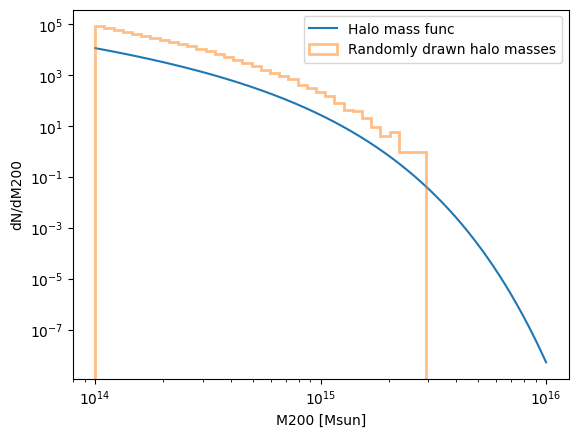

In [157]:
# to match with Robertson et al 2020: plt.plot(M200,mf*M200*np.log(10),label="Halo mass func")
plt.plot(M200,mf*M200*5e8,label="Halo mass func")
# cdf
# cdf = np.cumsum(mf*M200*np.log(10))
# plt.plot(M200,cdf,label="CDF")

## mf*M200 above because histogram binning, below, is in logspace  
plt.hist(M200_sample,bins = np.logspace(14,16,50),label="Randomly drawn halo masses", alpha=0.5, histtype='step', linewidth=2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("M200 [Msun]")
plt.ylabel("dN/dM200")
plt.legend()
plt.show()


## Using `colossus`

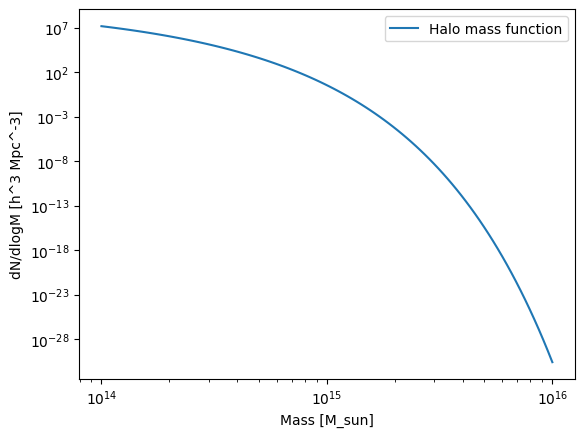

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from colossus.lss import mass_function

# Set up the cosmology
cosmology.setCosmology('planck18')

# Define the mass range and redshift
M = np.logspace(14, 16, 100)  # Mass range from 10^14 to 10^16 solar masses
z = 2  # Example redshift

# Calculate the halo mass function
hmf = mass_function.massFunction(M, z, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

# Plot the halo mass function
plt.plot(M, hmf * M, label='Halo mass function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass [M_sun]')
plt.ylabel('dN/dlogM [h^3 Mpc^-3]')
plt.legend()
plt.show()

# 2D rejection sampling with halo mass and redshift

* Create 2D pdf for halo mass and redshift
* Use rejection sampling to generate samples from the 2D pdf

In [272]:
import numpy as np
import lensprop as lp
import cosmology as cc
from constants import *

# Initialising cosmology for mass function, distances, etc. 
aum_cosm = cc.cosmology(Om0,Omk,w0,wa,Ob,h_H0,Tcmb0,sigma8,ns,np.log10(8.0),1.0)

Msun = 1.989e30
params = dict(
    zlmin = 0.2,
    zlmax = 1.7,
    Mmin = 1e14,
    Mmax = 1e16,
    aum_cosm = aum_cosm,
)

# initialising the class
class_ = lp.clusterProperties(params)

In [287]:
# Define the mass and redshift range
M = np.logspace(14, 16, 1000)  # Mass range from 10^14 to 10^16 solar masses
z = np.geomspace(0.1, 10, 1000)  # Redshift range from 0 to 10

# Calculate the halo mass function
hmf = np.zeros((len(M), len(z)))
for i in range(len(M)):
    for j in range(len(z)):
        hmf[i, j] = class_.get_halomassfunc(M[i], z[j])

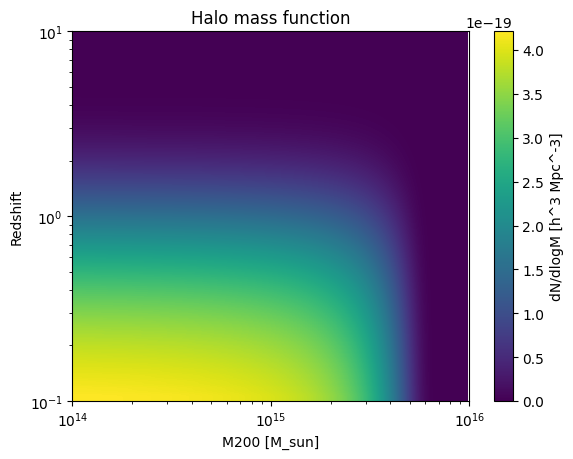

In [303]:
# Plot the halo mass function
# use imshow to plot the 2D array
plt.imshow(hmf, extent=(M[0], M[-1], z[0], z[-1]), aspect='auto', origin='lower')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M200 [M_sun]')
plt.ylabel('Redshift')
plt.title('Halo mass function')
plt.colorbar(label='dN/dlogM [h^3 Mpc^-3]')
plt.show()

In [294]:
# 2D rejection sampling function
def rejection_sample2d(pdf, xmin, xmax, ymin, ymax, size=100, chunk_size=100):
    """
        Helper function for rejection sampling from a 2D pdf with maximum and minimum arguments.

        Parameters
        ----------
        pdf : `function`
            2D pdf function.
        xmin : `float`
            minimum value of the pdf in the x-axis.
        xmax : `float`
            maximum value of the pdf in the x-axis.
        ymin : `float`
            minimum value of the pdf in the y-axis.
        ymax : `float`
            maximum value of the pdf in the y-axis.
        size : `int`, optional
            number of samples. Default is 100.
        chunk_size : `int`, optional
            chunk size for sampling. Default is 10000.

        Returns
        ----------
        x_sample : `numpy.ndarray`
            samples from the pdf in the x-axis.
    """

    x = np.random.uniform(xmin, xmax, chunk_size) # M
    y = np.random.uniform(ymin, ymax, chunk_size) # z

    # find the pdf value at x and y
    z = np.zeros(chunk_size)
    for i in range(chunk_size):
        z[i] = pdf(x[i], y[i])

    # Maximum value of the pdf
    zmax = np.max(z)
    
    # Rejection sample in chunks
    x_sample = []
    y_sample = []
    pdf_sample = []
    while len(x_sample) < size:
        x_try = np.random.uniform(xmin, xmax, size=chunk_size)
        y_try = np.random.uniform(ymin, ymax, size=chunk_size)
        pdf_xy_try = np.zeros(chunk_size)
        for i in range(chunk_size):
            pdf_xy_try[i] = pdf(x_try[i], y_try[i])

        # this is for comparing with the pdf value at x_try, will be used to accept or reject the sample
        z_try = np.random.uniform(0, zmax, size=chunk_size)
        
        # Update the maximum value of the pdf
        zmax = max(zmax, np.max(pdf_xy_try))

        idx = z_try < pdf_xy_try
        x_sample += list(x_try[idx])
        y_sample += list(y_try[idx])
        pdf_sample += list(pdf_xy_try[idx])

    # Transform the samples to a 1D numpy array
    x_sample = np.array(x_sample).flatten()
    y_sample = np.array(y_sample).flatten()
    pdf_sample = np.array(pdf_sample).flatten()
    # Return the correct number of samples
    return x_sample[-size:], y_sample[-size:], pdf_sample[-size:]

In [300]:
m_sample, zl_sample, pdf_sample = rejection_sample2d(
    pdf=class_.get_halomassfunc, 
    xmin=M[0],
    xmax=M[-1],
    ymin=z[0],
    ymax=z[-1],
    size=10000, 
    chunk_size=100000,
)

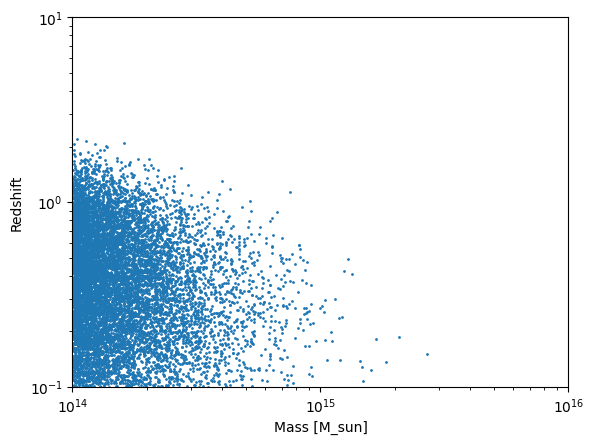

In [302]:
# scatter plot of the randomly drawn halo masses
plt.scatter(m_sample, zl_sample, s=1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Redshift')
plt.xlabel('Mass [M_sun]')
plt.xlim(M[0], M[-1])
plt.ylim(z[0], z[-1])
plt.show()